In [1]:
#basic imports and ipython setup
import matplotlib.pyplot as plt
import numpy as np

from MCEq.core import MCEqRun
import crflux.models as crf
import mceq_config as config
import crflux.models as pm

from tqdm import tqdm

from scipy.sparse import identity
from scipy.sparse import find

from scipy.linalg import expm

from functools import reduce

from time import time

import pandas as pd
from MCEq.geometry.density_profiles import GeneralizedTarget

import matplotlib as mpl
from cycler import cycler

In [2]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [3]:
# dX = config.stability_margin / (mceq.matrix_builder.max_ldec * rho(X))

In [4]:
# particles to include:
# mu : +/- 13
# pi0 : 111
# K_L0 : 130
# pi : +/- 211
# K_S0 : 310
# K : +/- 321
# D : +/- 411
# D0 : +/- 421
# D_s : +/- 431
# n0 : +/- 2122
# p : +/- 2212
# Lambda0 : +/- 3122

In [5]:
def surface_flux(cosTH, primary_model = (pm.GlobalSplineFitBeta, None), interaction_model = 'DPMJETIII191', density_model = ('CORSIKA',('SouthPole', 'December')), elev = 3120, sol=True, use_tqdm=False):
    import mceq_config as config
    
    config.debug_level = 0
    
    # Generic settings
    ## config.max_density = 1.
    config.h_obs = elev # elevation in (m) of Dome-C
    
    #config.hybrid_crossover = 0.3
    config.enable_default_tracking = False
    #config.adv_set["allowed_projectiles"] = [13, 111, 130, 211, 310, 321, 411, 421, 431, 2122, 2212, 3122]
    #config.adv_set["exclude_from_mixing"] = [13, 211, 321 ]#,2112, 3122
    #config.adv_set["force_resonance"] = [421, 411, 431, 111,310]
    ## config.adv_set["disabled_particles"] = [111]
    #config.e_min = 1e-3 # This is the lowest stable limit 60 MeV
    #config.e_max = 1e9
    #config.e_min = 1
    #config.e_max = 1e9
    #config.dXmax = 1.
    #config.leading_process = 'auto'
    #config.enable_energy_loss = True
    #config.average_loss_operator = True
    #config.loss_step_for_average = 1e-5
    #config.generic_losses_all_charged = True
    #config.enable_em_ion = True
    #config.enable_cont_rad_loss = False
    ##config.enable_em = True
    #config.excpt_on_missing_particle = True
    #config.muon_helicity_dependence = True
    ##: File name of the MCEq database
    #config.em_db_fname = "mceq_db_EM_Tsai_Max_v131.h5"
    #config.mceq_db_fname = 'mceq_db_lext_dpm191_v131_VM.h5'
    #density_model = ('CORSIKA',('SouthPole', 'December'))
    #density_model = ('CORSIKA', ('USStd', None))
    
    config.max_density = 0.001225
    config.dedx_material = 'air'

    mceq = MCEqRun(
        interaction_model=interaction_model,
        theta_deg = 180*np.arccos(cosTH)/np.pi,
        density_model = density_model,
        #medium=medium,
        primary_model = primary_model,
    )
    
    if sol:
        #mceq.solve()
        
        solve_mceq(mceq, use_tqdm=use_tqdm)
    
    return mceq

In [6]:
def depth_flux(flux, z, h, cosTH, rho=None, interaction_model = 'DPMJETIII191', sol=True, use_tqdm=False):
    #print('Calculating flux through ice at {:.1f} degrees'.format(180*np.arccos(cosTH)/np.pi))
    
    import mceq_config as config
    
    # Generic settings
    ## config.max_density = 1.
    #config.hybrid_crossover = 0.3
    config.enable_default_tracking = False
    #config.adv_set["exclude_from_mixing"] = [13, 211, 321 ]#,2112, 3122
    #config.adv_set["force_resonance"] = [421, 411, 431, 111,310]
    ## config.adv_set["disabled_particles"] = [111]
    #config.e_min = 1e-3 # This is the lowest stable limit 60 MeV
    #config.e_max = 1e9
    #config.e_min = 1
    #config.e_max = 1e9
    config.debug_level = 0 #2
    #config.dXmax = 1.
    #config.leading_process = 'auto'
    #config.enable_energy_loss = True
    #config.average_loss_operator = True
    #config.loss_step_for_average = 1e-5
    #config.generic_losses_all_charged = True
    #config.enable_em_ion = True
    #config.enable_cont_rad_loss = False
    #config.enable_em = True
    #config.excpt_on_missing_particle = True
    #config.muon_helicity_dependence = True
    ##: File name of the MCEq database
    #config.em_db_fname = "mceq_db_EM_Tsai_Max_v131.h5"
    #config.mceq_db_fname = 'mceq_db_lext_dpm191_v131_VM.h5'
    primary_model = (pm.GlobalSplineFitBeta, None)
    
    #medium = 'water'
    #density = 1.
    medium = 'ice'
    if rho is None:
        density = 0.9239
        ## medium = 'iron'
        ## density = 7.864
        target = GeneralizedTarget(len_target=h[-1]*100/cosTH/density) # 1km
        target.add_material(0.,density,medium)
    else:
        target = GeneralizedTarget(len_target=z[-1]*100/cosTH, env_density = rho_ice, env_name = 'ice')
        target.mat_list = [[z[i]*100/cosTH, z[i+1]*100/cosTH, rho[i], 'ice'] for i in range(len(z)-1)]
        target._update_variables()
    ## config.A_target = 18/3.
    config.max_density = 0.9239
    config.dedx_material = 'ice'

    mceq = MCEqRun(
        interaction_model = interaction_model,
        theta_deg = 0,
        density_model = target,
        medium=medium,
        primary_model = primary_model,
    )

    mceq._phi0 = flux
    
    if sol:
        #mceq.solve()
        #mceq.solve(int_grid=h/cosTH*100)
        
        solve_mceq(mceq, int_grid=h/cosTH*100, use_tqdm=use_tqdm)
    
    return mceq

In [7]:
def solve_mceq(mceq, int_grid=None, grid_var='X', use_tqdm=False):
    mceq._calculate_integration_path(int_grid=int_grid, grid_var=grid_var)

    nsteps, dX, rho_inv, grid_idcs = mceq.integration_path
    int_m = mceq.int_m
    dec_m = mceq.dec_m

    dXaccum = 0.
    grid_sol = np.zeros((len(grid_idcs), *np.shape(mceq._phi0)))
    grid_step = 0

    phc = np.copy(mceq._phi0)
    
    for step in (tqdm(range(nsteps)) if use_tqdm else range(nsteps)):
        phc += (int_m.dot(phc) + dec_m.dot(rho_inv[step] * phc)) * dX[step]
        phc[phc<1e-250] = 0.

        if (grid_idcs and grid_step < len(grid_idcs)
                and grid_idcs[grid_step] == step):
            grid_sol[grid_step] = np.copy(phc)
            grid_step += 1

    mceq._solution, mceq.grid_sol = phc, grid_sol
    
    return

In [8]:
def flux_matrix_one_ang(i_range, z, h, cosTH, rho=None, interaction_model = 'DPMJETIII191', elev = 3120):
    print('Calculating muon flux response at {:.1f} degrees'.format(180*np.arccos(cosTH)/np.pi))
    
    mceq = surface_flux(cosTH, interaction_model=interaction_model, elev=elev, sol=False)
    
    phi0 = np.zeros((len(mceq._phi0), len(i_range)))
    phi0[i_range,np.arange(len(i_range))] = 1.
    #phi0[i_range] = np.identity(len(i_range))
    
    mceq._phi0 = phi0
    solve_mceq(mceq, use_tqdm=True)
    
    print('Propagating through ice...')
    
    mceq_fin = depth_flux(mceq._solution, z, h, cosTH, rho, interaction_model = interaction_model, use_tqdm=True)
    
    print('Retrieving Muon Flux...')
    
    phi_sum = mceq_fin.grid_sol[:,4*121:5*121] + mceq_fin.grid_sol[:,5*121:6*121] + mceq_fin.grid_sol[:,6*121:7*121] + mceq_fin.grid_sol[:,7*121:8*121] + mceq_fin.grid_sol[:,8*121:9*121] + mceq_fin.grid_sol[:,9*121:10*121]
    phi_int = phi_sum * mceq_fin._energy_grid.w.reshape((1,-1,1))

    return mceq_fin._energy_grid.c, phi_int
    # axis0 : depth
    # axis1 : muon energy
    # axis2 : CR particle & energy

In [9]:
def flux_matrix_all(i_range, z, h, cosTH, dcosTH, rho=None, interaction_model = 'DPMJETIII191', elev = 3120):
    
    
    E_grid, phi_mu_tot = flux_matrix_one_ang(i_range, z, h, cosTH[0], rho, interaction_model = interaction_model, elev = elev)
    phi_mu_tot *= dcosTH
    for i in range(1,len(cosTH)):
        phi_mu_tot += flux_matrix_one_ang(i_range, z, h, cosTH[i], rho, interaction_model = interaction_model, elev = elev)[1] * dcosTH

    return E_grid, 2*np.pi*phi_mu_tot

In [10]:
def plot_surface_spectrum(mceqs, title='Muon Surface Spectrum'):
    p_surf = np.array([m.get_solution('mu-', integrate=True)+m.get_solution('mu+', integrate=True) for m in mceqs])
    X = p_surf[:,:30]

    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    ax.imshow(X, extent=[np.log10(mceqs[0]._energy_grid.b[0]), np.log10(mceqs[0]._energy_grid.b[30]), 1, 0], origin='upper', aspect='auto')
    ax.set(xlabel='log10 Energy [GeV]',
           #yscale='log',
           ylabel='cos theta')
    plt.title(title)
    plt.show()
    
    return X

In [11]:
def SDC(E0, cosTH):
    # Smith & Duller / Chatzidakis
    
    A = 0.002382 # fitting parameter
    r = 0.76 # Ratio of muon energy to pion energy
    a = 2.500e-3 # Muon rate of energy loss in air (GeV / (g/cm^2))
    y0 = 1000 # Atmosphere depth at sea level (g/cm^2)
    gamma = 8/3 # fitting parameter
    b_mu = 0.800 # Correction factor related to atmospheric temperature
    m_mu = 105.659e-3 # Rest mass of muon (GeV/c^2)
    tau_mu0 = 2.2e-6 # Mean lifetime of muon at rest (s)
    rho0 = 0.00123 # Density of atmosphere at sea level (g/cm^3)
    c = 3e10 # speed of light (cm/s)
    lambda_pi = 120 # Absorption mean free path of pions (g/cm^2)
    b = 0.771 # coefficient to modify the isothermal atmosphere approximation
    tau0 = 2.61e-8 # Mean lifetime of pion at rest (s)
    m_pi = 139.580e-3 # Rest mass of pion (GeV/c^2)
    j_pi = 148.16 # m_pi * y0 * c / (tau0 * rho0) GeV
    
    # energy of pion that produced muon
    E_pi = (E0 + a*y0*(1/cosTH - 0.100))/r
    
    B_mu = b_mu * m_mu * y0 / (c * tau_mu0 * rho0)
    
    # Probability for muons to reach sea level
    P_mu = (0.100 * cosTH * (1-a*(y0/cosTH - 100)/(r * E_pi)))**(B_mu / ((r*E_pi + 100*a)*cosTH))
    
    Phi_S = A * E_pi**(-gamma) * P_mu * lambda_pi * b * j_pi/(E_pi* cosTH + b * j_pi)
    
    return Phi_S

In [12]:
def mu_sources(mceq):
    int_m = mceq.int_m
    dec_m = mceq.dec_m
    
    row0, col0, val0 = find(int_m)
    row1, col1, val1 = find(dec_m)
    row, col = np.append(row0,row1), np.append(col0,col1)
    
    mu_ind = np.arange(mceq.pman.pname2pref['mu+_l'].lidx, mceq.pman.pname2pref['mu-_r'].uidx)
    
    s = np.copy(mu_ind)
    
    i = 0
    while len(s) != len(np.unique(col[np.isin(row, s).nonzero()[0]])) and i<100:
        s = np.unique(col[np.isin(row, s).nonzero()[0]])
        i+=1
        
    if i>=100:
        print('failed to converge')
    
    return s

In [13]:
def particle_products(pname, mceq):
    int_m = mceq.int_m
    dec_m = mceq.dec_m
    
    row0, col0, val0 = find(int_m)
    row1, col1, val1 = find(dec_m)
    row, col = np.append(row0,row1), np.append(col0,col1)
    
    s = np.arange(mceq.pman.pname2pref[pname].lidx, mceq.pman.pname2pref[pname].uidx)
    
    i = 0
    while len(s) != len(np.unique(row[np.isin(col, s).nonzero()[0]])) and i<100:
        s = np.unique(row[np.isin(col, s).nonzero()[0]])
        i+=1
        
    if i>=100:
        print('failed to converge')
    
    return s

In [14]:
def i_to_pname(i, mceq):
    return np.array(list(mceq.pman.pname2pref.keys()))[np.unique(i//len(mceq._energy_grid.c))]

In [15]:
age_scale_file = 'DomeC_age_scale_Apr2023.csv'
ice_eq_depth_file = 'Real_vs_ice_eq_depth.csv'

age_scale = pd.read_csv(age_scale_file)
ages = np.array(age_scale['ages']) # years
depths_real = np.array(age_scale['depths_real']) # meters

ice_eq_depth = pd.read_csv(ice_eq_depth_file)
real_z = ice_eq_depth['z'] # meters
ice_eq_z = ice_eq_depth['ice_eq_z'] # meters (ice-eq)

In [16]:
def z_to_t(z): # convert real depth to age
    return np.interp(z, depths_real, ages)

def t_to_z(t): # convert age to real depth
    return np.interp(t, ages, depths_real)

def z_to_h(z): # convert real depth to mass depth
    return np.interp(z, real_z, ice_eq_z)*rho_ice

def h_to_z(h): # convert mass depth to real depth
    return np.interp(h/rho_ice, ice_eq_z, real_z)

def h_to_t(h): # convert mass depth to age
    return z_to_t(h_to_z(h/rho_ice))

def t_to_h(t): # convert age to mass depth
    return z_to_h(t_to_z(t))*rho_ice

Text(0.5, 1.0, 'Ice Depth by Relative Age')

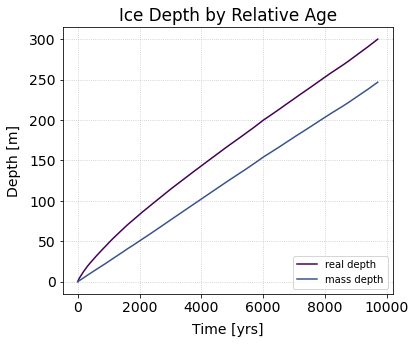

In [17]:
z_start = 0 # 96.5 # starting real depth of model (m)
z_deep = 300 # end depth (m)
rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)

i_start = np.argmin(abs(depths_real-z_start))
i_end = np.argmin(abs(depths_real-z_deep))
z = depths_real[i_start:i_end+1]
dz = depths_real[i_start+1:i_end+2] - z

h = z_to_h(z)
dh = z_to_h(depths_real[i_start+1:i_end+2]) - h
t = np.arange(len(z))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, z, label='real depth')
ax.plot(t, h, label='mass depth')
ax.set(xlabel='Time [yrs]',
       ylabel='Depth [m]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Depth by Relative Age')

Text(0.5, 1.0, 'Ice Density Profile')

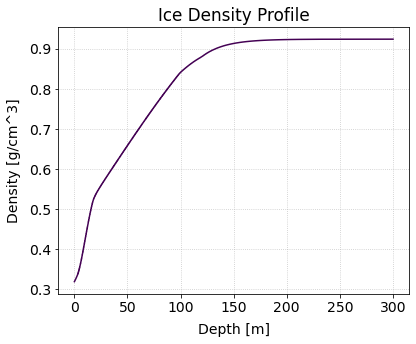

In [18]:
rho = dh/dz # calculate density from change in mass depth / real depth

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(z, rho)
ax.set(xlabel='Depth [m]',
       ylabel='Density [g/cm^3]')
#ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Density Profile')

In [19]:
dcosTH = 0.1
cosTH = np.arange(1,0,-dcosTH)

#dz = 1
#z = np.arange(0,300+dz, dz)

In [20]:
interaction_model = 'DPMJETIII191'
#interaction_model = "SIBYLL-2.3c"
#interaction_model = "EPOS-LHC"

In [21]:
phi_mu_tot = np.load('flux_mat_{}.npy'.format(interaction_model))

In [22]:
#E_grid, phi_mu_tot = flux_matrix_all(np.concatenate((np.arange(121)+31*121, np.arange(121)+29*121)), z, h, cosTH, dcosTH, rho=rho, interaction_model = interaction_model, elev = 3120)

In [23]:
#np.save('flux_mat_{}.npy'.format(interaction_model), phi_mu_tot)

In [24]:
mceq_surf = [surface_flux(cth) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.28s/it]


In [61]:
mceq_surf_0 = [surface_flux(cth, density_model = ('CORSIKA', ('USStd', None)), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]


In [15]:
mceq_surf_HG3_0 = [surface_flux(cth, primary_model = (pm.HillasGaisser2012, "H3a"), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.30s/it]


In [16]:
mceq_surf_HG4_0 = [surface_flux(cth, primary_model = (pm.HillasGaisser2012, "H4a"), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.37s/it]


In [17]:
mceq_surf_PG_0 = [surface_flux(cth, primary_model = (pm.PolyGonato, False), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.92s/it]


In [18]:
mceq_surf_GST3_0 = [surface_flux(cth, primary_model = (pm.GaisserStanevTilav, "3-gen"), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.99s/it]


In [19]:
mceq_surf_GST4_0 = [surface_flux(cth, primary_model = (pm.GaisserStanevTilav, "4-gen"), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.04s/it]


In [20]:
mceq_surf_GHHG_0 = [surface_flux(cth, primary_model = (pm.CombinedGHandHG, "H3a"), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.20s/it]


In [21]:
mceq_surf_ZSP_0 = [surface_flux(cth, primary_model = (pm.ZatsepinSokolskaya, "pamela"), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.66s/it]


In [22]:
mceq_surf_ZS_0 = [surface_flux(cth, primary_model = (pm.ZatsepinSokolskaya, "default"), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.50s/it]


In [23]:
mceq_surf_GH_0 = [surface_flux(cth, primary_model = (pm.GaisserHonda, None), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.08s/it]


In [24]:
mceq_surf_TIG_0 = [surface_flux(cth, primary_model = (pm.Thunman, None), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.13s/it]


In [25]:
mceq_surf_E27_0 = [surface_flux(cth, primary_model = (pm.SimplePowerlaw27, None), elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.25s/it]


In [26]:
mceq_surf_S23c_0 = [surface_flux(cth, primary_model = (pm.SimplePowerlaw27, None), interaction_model = "SIBYLL-2.3c", elev=0) for cth in tqdm(cosTH)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.69s/it]


In [19]:
mceq_test = surface_flux(1, primary_model = (pm.ZatsepinSokolskaya, "pamela"), interaction_model = "SIBYLL-2.3c", sol=False)

print(i_to_pname(mu_sources(mceq_test), mceq_test))
print(i_to_pname(np.nonzero(mceq_test._phi0)[0], mceq_test))

['mu+_l' 'mu+' 'mu+_r' 'mu-_l' 'mu-' 'mu-_r' 'pi0' 'K_L0' 'pi-' 'pi+'
 'K_S0' 'K-' 'K+' 'D-' 'D+' 'Dbar0' 'D0' 'D_s-' 'D_s+' 'nbar0' 'n0'
 'pbar-' 'p+' 'Lambdabar0' 'Lambda0']
['n0' 'p+']


In [38]:
a = mu_sources(mceq_test)
for i in range(34):
    b = a[a//121 == i]%121
    if len(b)>0:
        print("{}: {} GeV".format(i_to_pname(i*121, mceq_test), mceq_test._energy_grid.b[b[0]]))
    else:
        print("{} cannot produce muons".format(i_to_pname(i*121, mceq_test)))

['e+'] cannot produce muons
['e-'] cannot produce muons
['antinue'] cannot produce muons
['nue'] cannot produce muons
['mu+_l']: 0.07943282347242814 GeV
['mu+']: 0.07943282347242814 GeV
['mu+_r']: 0.07943282347242814 GeV
['mu-_l']: 0.07943282347242814 GeV
['mu-']: 0.07943282347242814 GeV
['mu-_r']: 0.07943282347242814 GeV
['antinumu'] cannot produce muons
['numu'] cannot produce muons
['antinutau'] cannot produce muons
['nutau'] cannot produce muons
['gamma'] cannot produce muons
['pi0']: 1000000000.0 GeV
['K_L0']: 19.952623149688808 GeV
['pi-']: 7.943282347242821 GeV
['pi+']: 7.943282347242821 GeV
['K_S0']: 7943.282347242822 GeV
['K-']: 79.43282347242821 GeV
['K+']: 79.43282347242821 GeV
['D-']: 1995262.3149688828 GeV
['D+']: 1995262.3149688828 GeV
['Dbar0']: 3981071.7055349695 GeV
['D0']: 3981071.7055349695 GeV
['D_s-']: 3981071.7055349695 GeV
['D_s+']: 3981071.7055349695 GeV
['nbar0']: 1.0 GeV
['n0']: 1.2589254117941675 GeV
['pbar-']: 1.0 GeV
['p+']: 1.2589254117941675 GeV
['Lambdab

In [48]:
np.nonzero(mceq_test._phi0)[0]%121

array([ 14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  8

In [20]:
i_to_pname(particle_products('n0', mceq_test), mceq_test)

array(['e+', 'e-', 'antinue', 'nue', 'mu+_l', 'mu+', 'mu+_r', 'mu-_l',
       'mu-', 'mu-_r', 'antinumu', 'numu', 'antinutau', 'nutau', 'gamma',
       'pi0', 'K_L0', 'pi-', 'pi+', 'K_S0', 'K-', 'K+', 'D-', 'D+',
       'Dbar0', 'D0', 'D_s-', 'D_s+', 'nbar0', 'n0', 'pbar-', 'p+',
       'Lambdabar0', 'Lambda0'], dtype='<U10')

In [21]:
i_to_pname(particle_products('p+', mceq_test), mceq_test)

array(['e+', 'e-', 'antinue', 'nue', 'mu+_l', 'mu+', 'mu+_r', 'mu-_l',
       'mu-', 'mu-_r', 'antinumu', 'numu', 'antinutau', 'nutau', 'gamma',
       'pi0', 'K_L0', 'pi-', 'pi+', 'K_S0', 'K-', 'K+', 'D-', 'D+',
       'Dbar0', 'D0', 'D_s-', 'D_s+', 'nbar0', 'n0', 'pbar-', 'p+',
       'Lambdabar0', 'Lambda0'], dtype='<U10')

In [35]:
mceq_test.pman

e+
   PDG id : (-11, 0)
   MCEq idx : 0

e-
   PDG id : (11, 0)
   MCEq idx : 1

antinue
   PDG id : (-12, 0)
   MCEq idx : 2

nue
   PDG id : (12, 0)
   MCEq idx : 3

mu+_l
   PDG id : (-13, -1)
   MCEq idx : 4

mu+
   PDG id : (-13, 0)
   MCEq idx : 5

mu+_r
   PDG id : (-13, 1)
   MCEq idx : 6

mu-_l
   PDG id : (13, -1)
   MCEq idx : 7

mu-
   PDG id : (13, 0)
   MCEq idx : 8

mu-_r
   PDG id : (13, 1)
   MCEq idx : 9

antinumu
   PDG id : (-14, 0)
   MCEq idx : 10

numu
   PDG id : (14, 0)
   MCEq idx : 11

antinutau
   PDG id : (-16, 0)
   MCEq idx : 12

nutau
   PDG id : (16, 0)
   MCEq idx : 13

gamma
   PDG id : (22, 0)
   MCEq idx : 14

pi0
   PDG id : (111, 0)
   MCEq idx : 15

K_L0
   PDG id : (130, 0)
   MCEq idx : 16

pi-
   PDG id : (-211, 0)
   MCEq idx : 17

pi+
   PDG id : (211, 0)
   MCEq idx : 18

K_S0
   PDG id : (310, 0)
   MCEq idx : 19

K-
   PDG id : (-321, 0)
   MCEq idx : 20

K+
   PDG id : (321, 0)
   MCEq idx : 21

D-
   PDG id : (-411, 0)
   MCEq idx : 22


In [50]:
print(np.arange(len(mceq_surf[0]._phi0[a]))[mceq_surf[0]._phi0[a] >0])

[1683 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696
 1697 1698 1699 1700 1701 1702 1703 1704 1705 1706 1707 1708 1709 1710
 1711 1712 1713 1714 1715 1716 1717 1718 1719 1720 1721 1722 1723 1724
 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736 1737 1738
 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751 1752
 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765 1766
 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779 1780
 1781 1782 1783 1784 1785 1786 1787 1788 1789 1902 1903 1904 1905 1906
 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920
 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934
 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 

In [51]:
np.nonzero(mceq_surf[0]._phi0)

(array([3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533,
        3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544,
        3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555,
        3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566,
        3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577,
        3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588,
        3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599,
        3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610,
        3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621,
        3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3765, 3766, 3767,
        3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778,
        3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789,
        3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800,
        3801, 3802, 3803, 3804, 3805, 

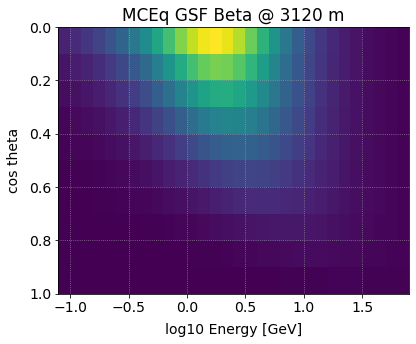

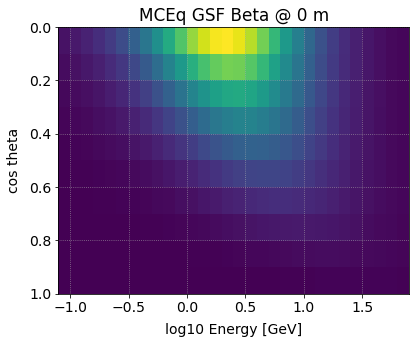

NameError: name 'mceq_surf_HG3_0' is not defined

In [62]:
X_surf = plot_surface_spectrum(mceq_surf, title='MCEq GSF Beta @ 3120 m')
X_surf_0 = plot_surface_spectrum(mceq_surf_0, title='MCEq GSF Beta @ 0 m')
X_surf_HG3_0 = plot_surface_spectrum(mceq_surf_HG3_0, title='MCEq HillasGaisser2012 H3a @ 0 m')
X_surf_HG4_0 = plot_surface_spectrum(mceq_surf_HG4_0, title='MCEq HillasGaisser2012 H4a @ 0 m')
X_surf_PG_0 = plot_surface_spectrum(mceq_surf_PG_0, title='MCEq PolyGonato @ 0 m')
X_surf_GST3_0 = plot_surface_spectrum(mceq_surf_GST3_0, title='MCEq GaisserStanevTilav 3-gen @ 0 m')
X_surf_GST4_0 = plot_surface_spectrum(mceq_surf_GST4_0, title='MCEq GaisserStanevTilav 4-gen @ 0 m')
X_surf_GHHG_0 = plot_surface_spectrum(mceq_surf_GHHG_0, title='MCEq CombinedGHandHG H3a @ 0 m')
X_surf_ZSP_0 = plot_surface_spectrum(mceq_surf_ZSP_0, title='MCEq ZatsepinSokolskaya pamela @ 0 m')
X_surf_ZS_0 = plot_surface_spectrum(mceq_surf_ZS_0, title='MCEq ZatsepinSokolskaya default @ 0 m')
X_surf_GH_0 = plot_surface_spectrum(mceq_surf_GH_0, title='MCEq GaisserHonda @ 0 m')
X_surf_TIG_0 = plot_surface_spectrum(mceq_surf_TIG_0, title='MCEq Thunman @ 0 m')
X_surf_E27_0 = plot_surface_spectrum(mceq_surf_E27_0, title='MCEq SimplePowerlaw27 @ 0 m')
X_surf_S23c_0 = plot_surface_spectrum(mceq_surf_S23c_0, title='MCEq E^2.7 SIBYLL-2.3c @ 0 m')

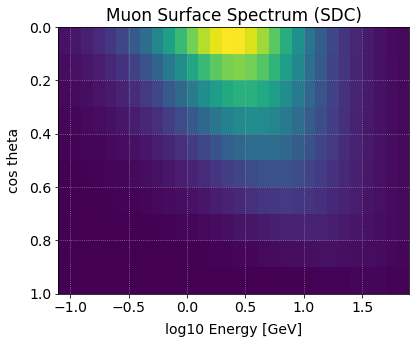

In [65]:
E_plt = np.expand_dims(mceq_surf[0]._energy_grid.c[:30],axis=1)
cos_plt = cosTH

Y = (SDC(E_plt, cos_plt)*E_plt).T
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.imshow(Y, extent=[np.log10(mceq_surf[0]._energy_grid.b[0]), np.log10(mceq_surf[0]._energy_grid.b[30]), 1, 0], origin='upper', aspect='auto')
ax.set(xlabel='log10 Energy [GeV]',
       #yscale='log',
       ylabel='cos theta')
plt.title('Muon Surface Spectrum (SDC)')
plt.show()

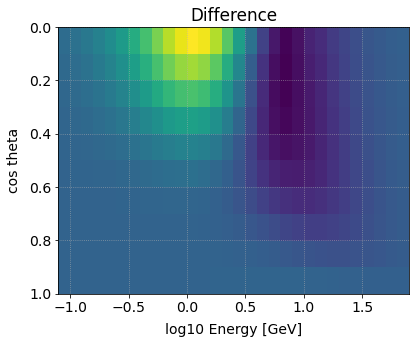

In [66]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.imshow(X_surf_0/np.sum(X_surf_0) - Y/np.sum(Y), extent=[np.log10(mceq_surf[0]._energy_grid.b[0]), np.log10(mceq_surf[0]._energy_grid.b[30]), 1, 0], origin='upper', aspect='auto')
ax.set(xlabel='log10 Energy [GeV]',
       #yscale='log',
       ylabel='cos theta')
plt.title('Difference')
plt.show()

In [30]:
mceq_depth = [depth_flux(mceq_surf[i]._solution, z, h, cosTH[i], rho) for i in range(len(cosTH))]

Calculating flux through ice at 0.0 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 24675.07g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:37<00:00, 257.95it/s]


Calculating flux through ice at 25.8 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 27416.74g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:36<00:00, 267.93it/s]


Calculating flux through ice at 36.9 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 30843.84g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:36<00:00, 269.18it/s]


Calculating flux through ice at 45.6 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 35250.10g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9706/9706 [00:35<00:00, 270.19it/s]


Calculating flux through ice at 53.1 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 41125.11g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:36<00:00, 267.74it/s]


Calculating flux through ice at 60.0 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 49350.14g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:35<00:00, 270.92it/s]


Calculating flux through ice at 66.4 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 61687.67g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9707/9707 [00:36<00:00, 266.99it/s]


Calculating flux through ice at 72.5 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 82250.23g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9730/9730 [00:35<00:00, 270.51it/s]


Calculating flux through ice at 78.5 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 123375.34g/cm2


100%|███████████████████████████████████████████████████████████████████████████| 19411/19411 [01:12<00:00, 269.57it/s]


Calculating flux through ice at 84.3 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 246750.69g/cm2


100%|███████████████████████████████████████████████████████████████████████████| 29139/29139 [01:49<00:00, 265.96it/s]


In [31]:
mceq_depth_0 = [depth_flux(mceq_surf_0[i]._solution, z, h, cosTH[i], rho) for i in range(len(cosTH))]

Calculating flux through ice at 0.0 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 24675.07g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:36<00:00, 267.03it/s]


Calculating flux through ice at 25.8 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 27416.74g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:37<00:00, 261.90it/s]


Calculating flux through ice at 36.9 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 30843.84g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:37<00:00, 259.52it/s]


Calculating flux through ice at 45.6 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 35250.10g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9706/9706 [00:37<00:00, 261.44it/s]


Calculating flux through ice at 53.1 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 41125.11g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:36<00:00, 263.50it/s]


Calculating flux through ice at 60.0 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 49350.14g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:37<00:00, 262.20it/s]


Calculating flux through ice at 66.4 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 61687.67g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9707/9707 [00:37<00:00, 260.51it/s]


Calculating flux through ice at 72.5 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 82250.23g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9730/9730 [00:37<00:00, 261.72it/s]


Calculating flux through ice at 78.5 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 123375.34g/cm2


100%|███████████████████████████████████████████████████████████████████████████| 19411/19411 [01:13<00:00, 264.07it/s]


Calculating flux through ice at 84.3 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 246750.69g/cm2


100%|███████████████████████████████████████████████████████████████████████████| 29139/29139 [01:52<00:00, 258.79it/s]


In [32]:
E_flux = np.expand_dims(mceq_surf[0]._energy_grid.c,axis=1)
SDC_flux = SDC(E_flux, cos_plt).T

# Negative muon ratio (Cited by Heisinger)
K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV]

phi_SDC = np.array([0*mceq_surf[0]._solution for cth in cosTH])
phi_SDC[:, mceq_surf[0].pman.pname2pref['mu+'].lidx : mceq_surf[0].pman.pname2pref['mu+'].uidx] = SDC_flux / (K_mu+1) # positive muons
phi_SDC[:, mceq_surf[0].pman.pname2pref['mu-'].lidx : mceq_surf[0].pman.pname2pref['mu-'].uidx] = SDC_flux / (1 + 1/K_mu) # negative muons

In [33]:
mceq_depth_SDC = [depth_flux(phi_SDC[i], z, h, cosTH[i], rho) for i in range(len(cosTH))]

Calculating flux through ice at 0.0 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 24675.07g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:37<00:00, 261.89it/s]


Calculating flux through ice at 25.8 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 27416.74g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:37<00:00, 259.69it/s]


Calculating flux through ice at 36.9 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 30843.84g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:37<00:00, 261.83it/s]


Calculating flux through ice at 45.6 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 35250.10g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9706/9706 [00:37<00:00, 255.50it/s]


Calculating flux through ice at 53.1 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 41125.11g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:37<00:00, 259.18it/s]


Calculating flux through ice at 60.0 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 49350.14g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9705/9705 [00:37<00:00, 259.55it/s]


Calculating flux through ice at 66.4 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 61687.67g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9707/9707 [00:37<00:00, 259.04it/s]


Calculating flux through ice at 72.5 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 82250.23g/cm2


100%|█████████████████████████████████████████████████████████████████████████████| 9730/9730 [00:43<00:00, 224.66it/s]


Calculating flux through ice at 78.5 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 123375.34g/cm2


100%|███████████████████████████████████████████████████████████████████████████| 19411/19411 [01:28<00:00, 219.99it/s]


Calculating flux through ice at 84.3 degrees
HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): DPMJETIII191
HDF5Backend::decay_db(): Using helicity dependent decays.
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:


Total number of species: 34
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::_calculate_integration_path(): X_surface = 246750.69g/cm2


100%|███████████████████████████████████████████████████████████████████████████| 29139/29139 [02:16<00:00, 213.28it/s]


In [38]:
# Is this step calculating the average momentum for a given depth and finding the atmospheric attenuation length
# for that momentum?

# If Attenuation varies by momentum, shouldn't the energy spectrum change as a result?


pressure = 65800 # surface pressure in Pa, should be 65800 for Dome C

# figure the difference in atmospheric depth from sea level in g/cm2
H = (1013.25 - pressure/100)*1.019716 # the 1.019716 number is basically just 1/g accounting for needed unit conversions

# define range/momentum relation
# table for muons in standard rock in Groom and others 2001

# g/cm^2
h_range = np.array([8.516e-1, 1.542e0, 2.866e0, 5.698e0, 9.145e0, 2.676e1, 3.696e1, 5.879e1, 9.332e1, 1.524e2,
                    2.115e2, 4.418e2, 5.534e2, 7.712e2, 1.088e3, 1.599e3, 2.095e3, 3.998e3, 4.920e3, 6.724e3,
                    9.360e3, 1.362e4, 1.776e4, 3.343e4, 4.084e4, 5.495e4, 7.459e4, 1.040e5, 1.302e5, 2.129e5])

# MeV/c
momentum = np.array([4.704e1, 5.616e1, 6.802e1, 8.509e1, 1.003e2, 1.527e2, 1.764e2, 2.218e2, 2.868e2, 3.917e2,
                     4.945e2, 8.995e2, 1.101e3, 1.502e3, 2.103e3, 3.104e3, 4.104e3, 8.105e3, 1.011e4, 1.411e4,
                     2.011e4, 3.011e4, 4.011e4, 8.011e4, 1.001e5, 1.401e5, 2.001e5, 3.001e5, 4.001e5, 8.001e5])

def att_L(h):
    # effective atmospheric attenuation length for muons at mass depth h
    
    P_MeVc = np.exp(np.interp(np.log(h*100), np.log(h_range), np.log(momentum)))
    
    return 263 + 150 * P_MeVc/1000

In [39]:
def phi_vert_slhl(h):
    #parameters
    p = [258.5,  #p0
        -5.5e-4, #p1
        210,     #p2
        10,      #p3
        1.66,    #p4
        75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    Phi_v = p[0] * a / b / c  # cm^-2 s^-1 sr^-1
    
    return Phi_v

In [40]:
def R_vert_slhl(h):
    #parameters
    p = [258.5,  #p0
        -5.5e-4, #p1
        210,     #p2
        10,      #p3
        1.66,    #p4
        75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    dadh = p[1] * a
    dbdh = 1.
    dcdh = p[4] * (h+p[3])**(p[4]-1)
    
    R_v = -p[0] * (b*c*dadh - a*c*dbdh - a*b*dcdh)/ b**2 / c**2  # hg^-1 s^-1 sr^-1
    
    return R_v

In [41]:
def phi_vert_site(h, dh, H=H, h_end=2e3):
    
    Phi_v= phi_vert_slhl(h)
    
    R_v = R_vert_slhl(h)
    
    R_site = R_v * np.exp(H/att_L(h))
    
    Phi_end = phi_vert_slhl(h_end)
    
    dh_ext = 1
    h_ext = np.arange(h[-1]+dh_ext, h_end+dh_ext, dh_ext)
    
    h_int = np.append(h, h_ext)
    dh_int = np.append(dh, dh_ext + 0*h_ext)
    
    R_int = R_vert_slhl(h_int) * np.exp(H/att_L(h_int))
    
    Phi_site = np.flip(np.cumsum(np.flip(R_int * dh_int))) + (1-np.exp(H/att_L(h_end)))*Phi_end
    
    Phi_site = Phi_site[:len(h)]
    
    #approximation where the exponential is almost constant in h
    #Phi_site = Phi_v * np.exp(H/att_L(h)) + (1-np.exp(H/att_L(h_end)))*Phi_end
    
    return Phi_site, R_site

In [42]:
def cos_pow(h, H=H):
    #parameters
    p = [3.21,     #p0
         0.297,    #p1
         42,       #p2
         1.21e-3]  #p3
    
    #H = (1013.25 - pressure/100) * 1.019716
    #h_mod = h + H (atmospheric depth diff. from sea level)
    
    # shouldn't H be subtracted here?
    
    n = p[0] - p[1]*np.log(h + H/100 + p[2]) + p[3] * (h + H/100)
    
    dndh = -p[1]/(h + H/100 + p[2]) + p[3]
    
    return n, dndh

In [43]:
def f_mu_neg(h = None):
    K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV]
    
    return 1/(K_mu+1)

In [44]:
def phi_all(h, dh, H=H, cos_pow_func=cos_pow, f_func=f_mu_neg):
    
    n, dndh = cos_pow_func(h, H)
    
    Phi_v, R_v = phi_vert_site(h, dh, H)
    
    Phi = 2*np.pi/(n+1) * Phi_v
    
    R = f_func(h) * (2*np.pi * R_v + Phi*dndh) / (n+1)
    
    return Phi, R # cm^-2 s^-1

In [45]:
Phi = phi_all(h, dh+h*0)[0]
Phi0 = phi_all(h, dh+h*0, H=0)[0]

C:\Users\walte\AppData\Local\Temp/ipykernel_10500/881969149.py:28: RuntimeWarning: divide by zero encountered in log
  P_MeVc = np.exp(np.interp(np.log(h*100), np.log(h_range), np.log(momentum)))


In [67]:
def get_primary(primary_model = (pm.GlobalSplineFitBeta, None)):
    mceq = surface_flux(0, primary_model=primary_model, sol=False)
    return mceq, np.concatenate((mceq._phi0[31*121:32*121], mceq._phi0[29*121:30*121]))

In [63]:
p_models = [(pm.GlobalSplineFitBeta, None), (pm.HillasGaisser2012, "H3a"), (pm.HillasGaisser2012, "H4a"), (pm.PolyGonato, False),
           (pm.GaisserStanevTilav, "3-gen"), (pm.GaisserStanevTilav, "4-gen"), (pm.CombinedGHandHG, "H3a"),
           (pm.ZatsepinSokolskaya, "pamela"), (pm.ZatsepinSokolskaya, "default"), (pm.GaisserHonda, None),
           (pm.Thunman, None), (pm.SimplePowerlaw27, None)]
model_names = ['GlobalSplineFitBeta', 'HillasGaisser2012 H3a', 'HillasGaisser2012 H4a', 'PolyGonato',
              'GaisserStanevTilav 3-gen', 'GaisserStanevTilav 4-gen', 'CombinedGHandHG H3a',
              'ZatsepinSokolskaya pamela', 'ZatsepinSokolskaya default', 'GaisserHonda',
              'Thunman', 'SimplePowerlaw27']

In [68]:
mceq = get_primary()[0]
E_grid = mceq._energy_grid.c

In [76]:
Primaries = [get_primary(p)[1] for p in p_models]

In [85]:
MU_spect = [phi_mu_tot @ phi0 for phi0 in Primaries]
MU_tot = [np.sum(mu_spect, axis=1) for mu_spect in MU_spect]
E_MU_avg = [np.sum(MU_spect[i]*E_grid, axis=1)/MU_tot[i] for i in range(len(MU_spect))]

Text(0.5, 1.0, 'Total Muon Flux over Depth')

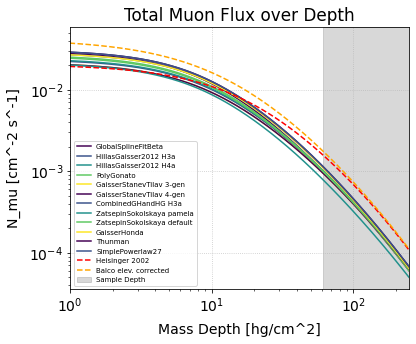

In [97]:
#config.return_as = 'kinetic energy'

#longitudinal_spectrum = np.array([[mceq_depth[i].get_solution('mu-', grid_idx=idx, integrate=True)+mceq_depth[i].get_solution('mu+', grid_idx=idx, integrate=True) for idx in range(len(h))] for i in range(len(cosTH))])
#Spec_tot = 2*np.pi*np.sum(longitudinal_spectrum*dcosTH, axis=(0,2)) # number of particles per cm^2 per s?

#longitudinal_spectrum_0 = np.array([[mceq_depth_0[i].get_solution('mu-', grid_idx=idx, integrate=True)+mceq_depth_0[i].get_solution('mu+', grid_idx=idx, integrate=True) for idx in range(len(h))] for i in range(len(cosTH))])
#Spec_tot_0 = 2*np.pi*np.sum(longitudinal_spectrum_0*dcosTH, axis=(0,2)) # number of particles per cm^2 per s?

#longitudinal_spectrum_SDC = np.array([[mceq_depth_SDC[i].get_solution('mu-', grid_idx=idx, integrate=True)+mceq_depth_SDC[i].get_solution('mu+', grid_idx=idx, integrate=True) for idx in range(len(h))] for i in range(len(cosTH))])
#Spec_tot_SDC = 2*np.pi*np.sum(longitudinal_spectrum_SDC*dcosTH, axis=(0,2)) # number of particles per cm^2 per s?

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
#ax.plot(h, Spec_tot_0, label='MCEq @ 0 m')
#ax.plot(h, Spec_tot_SDC, label='MCEq SDC @ 0 m')
#ax.plot(h, Spec_tot, label='MCEq @ 3120 m')
ax.plot(h, Phi0, ls='--', c='red', label='Heisinger 2002')
ax.plot(h, Phi, ls='--', c='orange', label='Balco elev. corrected')
ax.set(xlim = (1, h[-1]),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       yscale = 'log',
       ylabel='N_mu [cm^-2 s^-1]')
ax.legend(loc='lower left', fontsize=7)
plt.title('Total Muon Flux over Depth')

Text(0.5, 1.0, 'Total Muon Flux over Depth')

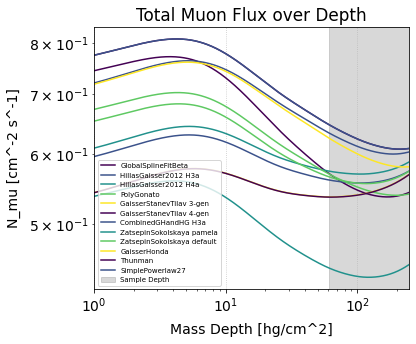

In [95]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
#ax.plot(h, Spec_tot_0/Phi0, label='MCEq @ 0 m')
#ax.plot(h, Spec_tot_SDC/Phi0, label='MCEq SDC @ 0 m')
#ax.plot(h, Spec_tot/Phi, label='MCEq @ 3120 m')
ax.set(xlim = (1, h[-1]),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       yscale = 'log',
       ylabel='N_mu [cm^-2 s^-1]')
ax.legend(loc='lower left', fontsize=7)
plt.title('Total Muon Flux over Depth')

Text(0.5, 1.0, 'Average Muon Energy over Depth')

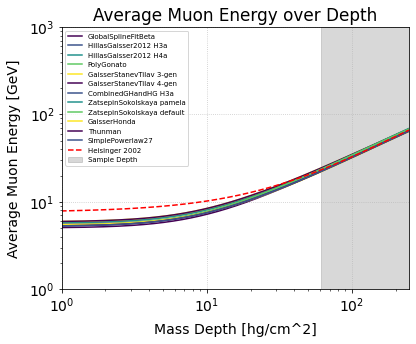

In [93]:
#E_avg = 2*np.pi*np.sum(longitudinal_spectrum * dcosTH * mceq_depth[0]._energy_grid.c, axis=(0,2))/Spec_tot
#E_avg_0 = 2*np.pi*np.sum(longitudinal_spectrum_0 * dcosTH * mceq_depth_0[0]._energy_grid.c, axis=(0,2))/Spec_tot_0
#E_avg_SDC = 2*np.pi*np.sum(longitudinal_spectrum_SDC * dcosTH * mceq_depth_SDC[0]._energy_grid.c, axis=(0,2))/Spec_tot_SDC

E_pred = 7.6 + 321.7 * (1-np.exp(-8.059e-4*h)) + 50.7*(1-np.exp(-5.05e-5*h)) #Heisinger 2002

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
#ax.plot(h, E_avg_0, label='MCEq @ 0 m')
#ax.plot(h, E_avg_SDC, label='MCEq SDC @ 0 m')
#ax.plot(h, E_avg, label='MCEq @ 3120 m')
ax.plot(h, E_pred, ls='--', c='red', label='Heisinger 2002')
ax.set(xlim = (1, h[-1]),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       ylim = (1,1000),
       yscale = 'log',
       ylabel='Average Muon Energy [GeV]')
ax.legend(loc='upper left', fontsize=7)
plt.title('Average Muon Energy over Depth')

Text(0.5, 1.0, 'Average Muon Energy over Depth')

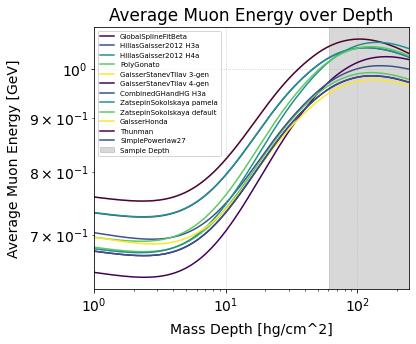

In [94]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
#ax.plot(h, E_avg_0/E_pred, label='MCEq @ 0 m')
#ax.plot(h, E_avg_SDC/E_pred, label='MCEq SDC @ 0 m')
#ax.plot(h, E_avg/E_pred, label='MCEq @ 3120 m')
ax.set(xlim = (1, h[-1]),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       #ylim = (1,1000),
       yscale = 'log',
       ylabel='Average Muon Energy [GeV]')
ax.legend(loc='upper left', fontsize=7)
plt.title('Average Muon Energy over Depth')

In [25]:
# Muon indices in MCEq flux matrices
# 'mu+_l' : 440-550
# 'mu+' : 550-660
# 'mu+_r' : 660-770
# 'mu-_l' : 770-880
# 'mu-' : 880-990
# 'mu-_r' : 990-1100
#
# obtained from mceq.pman.pname2pref[ particle ].lidx (.uidx)

In [52]:
#mceq = surface_flux(cosTH[0], sol=False)
mceq = mceq_surf[0]

In [83]:
mceq.pman.pname2pref['K_S0'].uidx

2420

In [88]:
mceq.pman.pname2pref.keys()

dict_keys(['e+', 'e-', 'antinue', 'nue', 'mu+_l', 'mu+', 'mu+_r', 'mu-_l', 'mu-', 'mu-_r', 'antinumu', 'numu', 'antinutau', 'nutau', 'gamma', 'pi0', 'K_L0', 'pi-', 'pi+', 'K_S0', 'K-', 'K+', 'D-', 'D+', 'Dbar0', 'D0', 'D_s-', 'D_s+', 'nbar0', 'n0', 'pbar-', 'p+', 'Lambdabar0', 'Lambda0'])

In [85]:
print(a[1100])

2404


In [27]:
mceq._calculate_integration_path(None, 'X')
phi0 = np.copy(mceq._phi0)
nsteps, dX, rho_inv, grid_idcs = mceq.integration_path
int_m = mceq.int_m
dec_m = mceq.dec_m

MCEqRun::_calculate_integration_path(): X_surface =  665.16g/cm2


In [28]:
row, col, val = find(int_m)
row1, col1, val1 = find(dec_m)
row, col = np.append(row,row1), np.append(col,col1)

In [29]:
# how many columns connect to rows 440-1100?
len(np.unique(col[np.in1d(row, np.arange(440,1100)).nonzero()[0]]))

1713

In [30]:
# how many columns connect to rows whose columns connect to 440-1100?
len(np.unique(col[np.in1d(row, np.unique(col[np.in1d(row, np.arange(440,1100)).nonzero()[0]])).nonzero()[0]]))

1725

In [31]:
# how many columns connect to rows whose columns connect to rows whose columns connect to 440-1100?
len(np.unique(col[np.in1d(row, np.unique(col[np.in1d(row, np.unique(col[np.in1d(row, np.arange(440,1100)).nonzero()[0]])).nonzero()[0]])).nonzero()[0]]))

1725

In [32]:
# indices of all particles involved in the creation and propagation of muons
mu_ind = np.unique(col[np.in1d(row, np.unique(col[np.in1d(row, np.unique(col[np.in1d(row, np.arange(440,1100)).nonzero()[0]])).nonzero()[0]])).nonzero()[0]])
print(mu_ind)

[ 440  441  442 ... 2857 2858 2859]


In [33]:
int_mu = int_m[mu_ind][:,mu_ind]
dec_mu = dec_m[mu_ind][:,mu_ind]
phi0_mu = phi0[mu_ind]

In [34]:
(int_mu + dec_mu*rho_inv[0])*dX[0] + identity(len(mu_ind))

<1725x1725 sparse matrix of type '<class 'numpy.float64'>'
	with 773493 stored elements in Compressed Sparse Row format>

In [35]:
#Matrices = [(int_mu + dec_mu*rho_inv[i])*dX[i] + identity(len(mu_ind)) for i in tqdm(range(nsteps))]

  6%|████▏                                                                    | 27674/487057 [08:35<2:17:14, 55.79it/s]

MemoryError: Unable to allocate 2.95 MiB for an array with shape (773709,) and data type int32

In [ ]:
#M = identity(len(mu_ind))
#for i in tqdm(range(nsteps)):
    #M = ((int_mu + dec_mu*rho_inv[i])*dX[i] + identity(len(mu_ind))) @ M